In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
DATA_DIR = '/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl-big-data-bowl-2026-prediction/train'

# confirm existence
os.listdir(DATA_DIR)[:5]

['input_2023_w01.csv',
 'input_2023_w02.csv',
 'input_2023_w03.csv',
 'input_2023_w04.csv',
 'input_2023_w06.csv']

## Load the Data

In [ ]:
import pandas as pd
import glob

def load_many(pattern):
  # Build the full path pattern such as "train/input_2023_w*.csv"
  search_path = os.path.join(DATA_DIR, pattern)
  files = sorted(glob.glob(search_path))

  # Read each CSV file and collect them in a list
  dfs = [pd.read_csv(f) for f in files]

  # Combine all DataFrames into one large table
  combined = pd.concat(dfs, ignore_index=True)
  return combined

Given inp, now we add two columns vx and vy for the velocity on x-axis and velocity on y-axis respectively.

In [ ]:
import numpy as np

# Add velocity components vx, vy from speed (s) and direction (dir in degrees)
def add_vx_vy(df_group):
    g = df_group.sort_values("frame_id")
    rad = np.deg2rad(g["dir"].to_numpy())
    vx = g["s"].to_numpy() * np.cos(rad)
    vy = g["s"].to_numpy() * np.sin(rad)
    return g.assign(vx=vx, vy=vy)

### Helper Function: Load or Create

In [ ]:
def load_or_create(drive_path, local_path, create_func):
    """
    Checks if a file exists on Drive. If so, copies to local and loads.
    If not, runs create_func(), saves the result, and copies to Drive.
    """
    if os.path.exists(drive_path):
        print(f"Found existing file on Google Drive: {os.path.basename(drive_path)}. Loading...")
        # Copy from Drive to local
        !cp "{drive_path}" {local_path}

        # Load based on file type
        if local_path.endswith('.parquet'):
            df = pd.read_parquet(local_path)
        elif local_path.endswith('.csv'):
            df = pd.read_csv(local_path)
        else:
            raise ValueError(f"Unsupported file type for {local_path}")

        print("Successfully loaded. ✅")

    else:
        print(f"No file found at {drive_path}. Creating it now...")
        # Run the provided function to get the data
        df = create_func()

        print(f"Saving new file locally to: {local_path}...")

        # Save based on file type
        if local_path.endswith('.parquet'):
            df.to_parquet(local_path, index=False)
        elif local_path.endswith('.csv'):
            df.to_csv(local_path, index=False)
        else:
            raise ValueError(f"Unsupported file type for {local_path}")

        print("Copying new file to Google Drive...")
        # Copy from local to Drive
        !cp {local_path} "{drive_path}"
        print(f"New file created and saved. ✅")

    return df

### Create A Single Input File

In [ ]:
local_processed_path = "inp_processed.parquet"
drive_processed_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/inp_processed.parquet"

def create_inp_processed():
    print(f"No processed file found. Loading raw data and creating it...")
    inp = load_many('input_2023_w*.csv')

    # --- Add velocity components vx, vy ---
    print("Adding velocity components (vx, vy)...")
    inp = (inp
           .groupby(["game_id","play_id","nfl_id"], group_keys=False)
           .apply(add_vx_vy)
           .reset_index(drop=True))
    return inp

# Use the helper function
inp = load_or_create(
    drive_path=drive_processed_path,
    local_path=local_processed_path,
    create_func=create_inp_processed
)

# --- Load the 'out' data ---
print("\nLoading 'out' data...")
out = load_many('output_2023_w*.csv')
print("'out' data loaded successfully. ✅")

Found existing file on Google Drive: inp_processed.parquet. Loading...
Successfully loaded. ✅

Loading 'out' data...
'out' data loaded successfully. ✅


### Split Train/Val/Test by Game

In [ ]:
def split_by_game(df_inp, seed=1337, train=0.70, val=0.15):
    games = np.array(sorted(df_inp["game_id"].unique()))
    rng = np.random.default_rng(seed)
    rng.shuffle(games)
    n = len(games)
    n_train = int(train*n)
    n_val = int(val*n)
    g_train = set(games[:n_train])
    g_val = set(games[n_train:n_train+n_val])
    g_test = set(games[n_train+n_val:])
    return g_train, g_val, g_test

In [ ]:
# Define paths
local_path = "game_splits.csv"
drive_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/game_splits.csv"

# Game splits
def create_game_splits():
    # 'inp' is in memory from the cell above
    g_train, g_val, g_test = split_by_game(inp, seed=1337)

    split_df = pd.DataFrame({
        "game_id": list(g_train) + list(g_val) + list(g_test),
        "split":   (["train"]*len(g_train) + ["val"]*len(g_val) + ["test"]*len(g_test))
    })
    return split_df

# Use the helper function
split_df = load_or_create(
    drive_path=drive_path,
    local_path=local_path,
    create_func=create_game_splits
)

# Verify the result
print("\n--- Split Info ---")
print(split_df['split'].value_counts())

Found existing file on Google Drive: game_splits.csv. Loading...
Successfully loaded. ✅

--- Split Info ---
split
train    190
test      42
val       40
Name: count, dtype: int64


In [ ]:
g_train = set(split_df[split_df['split'] == 'train']['game_id'])
g_val   = set(split_df[split_df['split'] == 'val']['game_id'])
g_test  = set(split_df[split_df['split'] == 'test']['game_id'])

print(f"Successfully loaded {len(g_train)} train, {len(g_val)} val, and {len(g_test)} test games.")

def summarize(name, game_set):
    df = inp[inp["game_id"].isin(game_set)]
    n_plays = df[["game_id","play_id"]].drop_duplicates().shape[0]
    print(f"[{name:5}] games={len(game_set):4d}  plays={n_plays:6d}  frames={len(df):9d}  unique players={df['nfl_id'].nunique():5d}")

summarize("TRAIN", g_train)
summarize("VAL",   g_val)
summarize("TEST",  g_test)

# Ensure no overlap between splits
assert g_train.isdisjoint(g_val) and g_train.isdisjoint(g_test) and g_val.isdisjoint(g_test), "Game splits overlap!"

Successfully loaded 190 train, 40 val, and 42 test games.
[TRAIN] games= 190  plays=  9794  frames=  3389897  unique players= 1318
[VAL  ] games=  40  plays=  2151  frames=   751897  unique players=  907
[TEST ] games=  42  plays=  2163  frames=   738785  unique players=  895


### Combine Input and Output

---



In [ ]:
# --- Define paths ---
local_merged_path = "data_merged.parquet"
drive_merged_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_merged.parquet"

# --- Merge input and output ---
def create_data_merged():
    # 'inp' and 'out' are in memory

    # Get the single last frame from the input trajectory
    print("Filtering 'inp' to get the single last frame of each player's history...")

    inp_start_frame = inp.sort_values('frame_id').groupby(
        ['game_id', 'play_id', 'nfl_id']
    ).last().reset_index()

    # Rename output 'frame_id' to avoid conflicts
    out_renamed = out.rename(columns={'frame_id': 'frame_id_future'})

    # Perform the one-to-many merge
    print("Merging the single start frame onto the full 'out' trajectory...")
    data = inp_start_frame.merge(
        out_renamed,
        on=['game_id', 'play_id', 'nfl_id'],
        how='left',
        suffixes=('_inp', '_out')
    )

    # Add split info
    print("Merging 'split_df' information...")
    data = data.merge(split_df, on='game_id', how='left')

    # Clean up columns
    data = data.rename(columns={'frame_id': 'frame_id_start_input'})

    return data

# Use the helper function
data = load_or_create(
    drive_path=drive_merged_path,
    local_path=local_merged_path,
    create_func=create_data_merged
)

print("\n--- Head of Final Merged Data ---")
print(data.head())

Found existing file on Google Drive: data_merged.parquet. Loading...
Successfully loaded. ✅

--- Head of Final Merged Data ---
      game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
0  2023090700      101   43290              False                    26   
1  2023090700      101   44930               True                    26   
2  2023090700      101   44930               True                    26   
3  2023090700      101   44930               True                    26   
4  2023090700      101   44930               True                    26   

  play_direction  absolute_yardline_number    player_name player_height  \
0          right                        42     Jared Goff           6-4   
1          right                        42  Josh Reynolds           6-3   
2          right                        42  Josh Reynolds           6-3   
3          right                        42  Josh Reynolds           6-3   
4          right                        42  Jos

## ML Pipeline: Feature Engineering

### Row-wise Feature Engineering

In [ ]:
# --- Define paths for the feature-engineered DataFrame ---
local_merged_path = "data_merged.parquet"
drive_merged_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_merged.parquet"

local_features_path = "data_features.parquet"
drive_features_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_features.parquet"

def create_features():
    print(f"Loading 'data_merged.parquet' to create features...")

    !cp "{drive_merged_path}" {local_merged_path}
    df = pd.read_parquet(local_merged_path)

    # --- Ball-Relative Features ---
    print("Engineering ball-relative features...")
    df['dist_to_ball_land'] = np.sqrt(
        (df['ball_land_x'] - df['x_inp'])**2 +
        (df['ball_land_y'] - df['y_inp'])**2
    )
    df['angle_to_ball_land'] = np.arctan2(
        df['ball_land_y'] - df['y_inp'],
        df['ball_land_x'] - df['x_inp']
    )

    # --- Kinematic Features ---
    print("Engineering kinematic features...")
    vec_x_to_ball = df['ball_land_x'] - df['x_inp']
    vec_y_to_ball = df['ball_land_y'] - df['y_inp']
    df['vel_to_ball_land'] = np.where(
        df['dist_to_ball_land'] > 0,
        (df['vx'] * vec_x_to_ball + df['vy'] * vec_y_to_ball) / df['dist_to_ball_land'],
        0
    )

    # --- Contextual (Binary) Features ---
    print("Engineering contextual features...")
    if 'player_role' in df.columns:
        df['is_targeted_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(int)
    if 'player_side' in df.columns:
        df['is_offense'] = (df['player_side'] == 'Offense').astype(int)
        df['is_defense'] = (df['player_side'] == 'Defense').astype(int)

    # --- Time-Based ---
    print("Engineering time-based features...")
    TIME_STEP = 0.1 # 0.1 seconds per frame

    # Feature 1: The future frame number (1, 2, ... 21)
    # We already have this: 'frame_id_future'

    # Feature 2: The actual time in seconds (0.1s, 0.2s, ... 2.1s)
    df['time_to_predict'] = df['frame_id_future'] * TIME_STEP

    # Feature 3: Percentage of the play that has elapsed
    # (e.g., frame 1 of 21 = 0.047, frame 21 of 21 = 1.0)
    df['pct_time_elapsed'] = df['frame_id_future'] / (df['num_frames_output'] + 1e-6)

    return df

# Use the helper function
data = load_or_create(
    drive_path=drive_features_path,
    local_path=local_features_path,
    create_func=create_features
)

# Print the head and new columns to verify
print("\n--- Head of Feature-Engineered Data ---")
print(data.head())

print("\n--- New Columns Created ---")
new_cols = ['dist_to_ball_land', 'angle_to_ball_land', 'vel_to_ball_land',
            'is_targeted_receiver', 'is_offense', 'is_defense',
            'frame_id_future', 'time_to_predict', 'pct_time_elapsed'] # <-- New features here

existing_new_cols = [col for col in new_cols if col in data.columns]
if existing_new_cols:
    print(data[existing_new_cols].describe())

Found existing file on Google Drive: data_features.parquet. Loading...
Successfully loaded. ✅

--- Head of Feature-Engineered Data ---
      game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
0  2023090700      101   43290              False                    26   
1  2023090700      101   44930               True                    26   
2  2023090700      101   44930               True                    26   
3  2023090700      101   44930               True                    26   
4  2023090700      101   44930               True                    26   

  play_direction  absolute_yardline_number    player_name player_height  \
0          right                        42     Jared Goff           6-4   
1          right                        42  Josh Reynolds           6-3   
2          right                        42  Josh Reynolds           6-3   
3          right                        42  Josh Reynolds           6-3   
4          right                       

### Group-wise and Relational Feature Engineering

In [ ]:
from scipy.spatial import cKDTree
from tqdm.auto import tqdm # For a progress bar!
import numpy as np

# --- Define paths ---
local_features_path = "data_features.parquet"
drive_features_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_features.parquet"

local_relational_path = "data_relational.parquet"
drive_relational_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_relational.parquet"

# --- Helper function to run on one frame at a time ---

def find_nearest_opponent(frame_df):
    """
    Calculates the distance to the nearest opponent for each player
    at a specific future frame (using x_out, y_out).
    """
    # Make a copy to avoid SettingWithCopyWarning
    frame = frame_df.copy()

    # --- Drop NaNs ---
    # Drop any players who don't have an output coordinate (e.g., the passer)
    frame_with_coords = frame.dropna(subset=['x_out', 'y_out'])

    # Get all offense/defense players
    off_players = frame_with_coords[frame_with_coords['is_offense'] == 1]
    def_players = frame_with_coords[frame_with_coords['is_defense'] == 1]

    # Initialize the new column with NaN
    frame['dist_to_nearest_opp'] = np.nan

    # Check if we have both offense and defense players
    if off_players.empty or def_players.empty:
        return frame # Not a valid frame, return

    # --- Build the trees ---
    def_tree = cKDTree(data=def_players[['x_out', 'y_out']])
    off_tree = cKDTree(data=off_players[['x_out', 'y_out']])

    # --- Query 1: Find nearest defender for each offensive player ---
    off_dists, _ = def_tree.query(off_players[['x_out', 'y_out']], k=1)

    # --- Query 2: Find nearest offensive player for each defender ---
    def_dists, _ = off_tree.query(def_players[['x_out', 'y_out']], k=1)

    # --- Assign the results back to the frame ---
    frame.loc[off_players.index, 'dist_to_nearest_opp'] = off_dists
    frame.loc[def_players.index, 'dist_to_nearest_opp'] = def_dists

    return frame

# --- The create function (to pass to load_or_create) ---
def create_relational_features():
    print(f"Loading 'data_features.parquet' to create relational features...")
    !cp "{drive_features_path}" {local_features_path}
    df = pd.read_parquet(local_features_path)

    # --- Group by the future frame ID ---
    group_keys = ['game_id', 'play_id', 'frame_id_future']

    print("Calculating nearest opponent distances (for each future frame)...")
    tqdm.pandas(desc="Processing Frames")

    # --- Group on the 'df' DataFrame ---
    data_rel = (
        df.groupby(group_keys, as_index=False, group_keys=False)
             .progress_apply(find_nearest_opponent)
    )

    print("Relational features created.")
    return data_rel

# --- Use the helper function ---
data = load_or_create(
    drive_path=drive_relational_path,
    local_path=local_relational_path,
    create_func=create_relational_features
)

# --- Verify the new column ---
print("\n--- Head of Relational-Feature Data ---")
print(data.head())

print("\n--- New Column 'dist_to_nearest_opp' ---")
# Check the new column (and a few old ones)
verify_cols = ['dist_to_ball_land', 'is_offense', 'dist_to_nearest_opp']
print(data[verify_cols].describe())

Found existing file on Google Drive: data_relational.parquet. Loading...
Successfully loaded. ✅

--- Head of Relational-Feature Data ---
      game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
0  2023090700      101   44930               True                    26   
1  2023090700      101   44930               True                    26   
2  2023090700      101   44930               True                    26   
3  2023090700      101   44930               True                    26   
4  2023090700      101   44930               True                    26   

  play_direction  absolute_yardline_number    player_name player_height  \
0          right                        42  Josh Reynolds           6-3   
1          right                        42  Josh Reynolds           6-3   
2          right                        42  Josh Reynolds           6-3   
3          right                        42  Josh Reynolds           6-3   
4          right                     

#### Add Frame-Level & Relational Features (Separation, Closing Speed)

In [ ]:
# --- Define paths (same as before) ---
local_relational_path = "data_relational.parquet"
drive_relational_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_relational.parquet"
local_final_path = "data_final_features.parquet"
drive_final_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_final_features.parquet"


# --- HELPER FUNCTION: to reduce memory ---
def downcast_dtypes(df):
    """Reduces memory usage of a DataFrame by downcasting numeric types."""
    print(f"Original memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    float_cols = df.select_dtypes(include='float').columns
    df[float_cols] = df[float_cols].astype('float32')

    int_cols = df.select_dtypes(include='integer').columns
    for col in int_cols:
        if df[col].min() >= 0 and df[col].max() <= 1:
            df[col] = df[col].astype('int8')
        elif df[col].min() >= np.iinfo('int16').min and df[col].max() <= np.iinfo('int16').max:
            df[col] = df[col].astype('int16')
        elif df[col].min() >= np.iinfo('int32').min and df[col].max() <= np.iinfo('int32').max:
            df[col] = df[col].astype('int32')

    print(f"New memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    return df


# --- Using .transform() for memory safety ---
def create_final_features_mem_safe():
    print(f"Loading 'data_relational.parquet'...")
    !cp "{drive_relational_path}" {local_relational_path}
    df = pd.read_parquet(local_relational_path)

    print("Downcasting dtypes to save RAM...")
    df = downcast_dtypes(df)

    group_keys = ['game_id', 'play_id', 'frame_id_future']

    print("Engineering frame-level features (using groupby.transform)...")

    """
    These are frame-level context features. Every player in the frame should know:
    1. What's the target's separation right now?
    2. How fast is the target moving toward the ball?
    """

    # Create the features only for the target receiver
    df['frame_separation'] = np.where(
        df['is_targeted_receiver'] == 1,
        df['dist_to_nearest_opp'],
        np.nan
    ).astype('float32')

    df['frame_target_vel_to_ball'] = np.where(
        df['is_targeted_receiver'] == 1,
        df['vel_to_ball_land'],
        np.nan
    ).astype('float32')

    # Use transform() to broadcast the target's value to all players in the frame
    print("Broadcasting target's info to all players...")
    df['frame_separation'] = df.groupby(group_keys)['frame_separation'].transform('first')
    df['frame_target_vel_to_ball'] = df.groupby(group_keys)['frame_target_vel_to_ball'].transform('first')

    # Fill NaNs for the broadcasted columns first.
    print("Filling NaNs for broadcasted features...")
    df['frame_separation'] = df['frame_separation'].fillna(0)
    df['frame_target_vel_to_ball'] = df['frame_target_vel_to_ball'].fillna(0)

    # Create 'closing_speed' feature
    print("Calculating closing speed...")
    df['closing_speed_on_target'] = (df['vel_to_ball_land'] - df['frame_target_vel_to_ball']).astype('float32')

    # Handle any remaining NaNs
    df['closing_speed_on_target'] = df['closing_speed_on_target'].fillna(0)

    print("Final features created.")
    return df

# --- Use the helper function ---
data = load_or_create(
    drive_path=drive_final_path,
    local_path=local_final_path,
    create_func=create_final_features_mem_safe
)

# --- Verify the new columns ---
print("\n--- Head of Final Feature Data ---")
print(data.head())

print("\n--- New Columns ('frame_separation', 'closing_speed_on_target') ---")
verify_cols = ['frame_separation', 'frame_target_vel_to_ball', 'closing_speed_on_target']
print(data[verify_cols].describe())

print("\n--- Final Data Types (to check memory) ---")
print(data.info())

Found existing file on Google Drive: data_final_features.parquet. Loading...
Successfully loaded. ✅

--- Head of Final Feature Data ---
      game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
0  2023090700      101   44930               True                    26   
1  2023090700      101   44930               True                    26   
2  2023090700      101   44930               True                    26   
3  2023090700      101   44930               True                    26   
4  2023090700      101   44930               True                    26   

  play_direction  absolute_yardline_number    player_name player_height  \
0          right                        42  Josh Reynolds           6-3   
1          right                        42  Josh Reynolds           6-3   
2          right                        42  Josh Reynolds           6-3   
3          right                        42  Josh Reynolds           6-3   
4          right                      

# Training with LightGBM

In [ ]:
import numpy as np
import pandas as pd

model_df = data[data['x_out'].notna()].copy()

print(f"Total frames to train/val on: {len(model_df)}")

# --- Define feature columns and target columns ---
feature_cols = [
    # Original input features
    'x_inp', 'y_inp', 's', 'a', 'dir', 'o', 'vx', 'vy',
    'num_frames_output',

    # --- Newly added time features ---
    'frame_id_future',
    'time_to_predict',
    'pct_time_elapsed',

    # Static ball-relative features
    'dist_to_ball_land', 'angle_to_ball_land', 'vel_to_ball_land',

    # Contextual features
    'is_targeted_receiver', 'is_offense', 'is_defense',

    # Dynamic & relational features
    'dist_to_nearest_opp', 'frame_separation',
    'frame_target_vel_to_ball', 'closing_speed_on_target',
]

target_cols = ['x_out', 'y_out']

# --- Create final train/val/test splits using the 'split' column ---
X_train = model_df[model_df['split'] == 'train'][feature_cols]
y_train = model_df[model_df['split'] == 'train'][target_cols]

X_val = model_df[model_df['split'] == 'val'][feature_cols]
y_val = model_df[model_df['split'] == 'val'][target_cols]

X_test = model_df[model_df['split'] == 'test'][feature_cols]
y_test = model_df[model_df['split'] == 'test'][target_cols]

print(f"Training on {len(X_train)} frames.")
print(f"Validating on {len(X_val)} frames.")
print(f"Testing on {len(X_test)} frames.")

Total frames to train/val on: 562936
Training on 388089 frames.
Validating on 87154 frames.
Testing on 87693 frames.


### Baseline Model

In [ ]:
TIME_STEP = 0.1 # 0.1 seconds per frame

t_val = X_val['time_to_predict']

# --- Constant acceleration model ---
# Compute ax and ay using a and dir
print("Calculating Constant Acceleration baseline...")
rad = np.deg2rad(X_val["dir"])
ax_val = X_val["a"] * np.cos(rad)
ay_val = X_val["a"] * np.sin(rad)

# --- Baseline predictions ---
# x_new = x_old + (vx * t) + (0.5 * ax * t^2)
x_pred_baseline = X_val['x_inp'] + (X_val['vx'] * t_val) + (0.5 * ax_val * t_val**2)
y_pred_baseline = X_val['y_inp'] + (X_val['vy'] * t_val) + (0.5 * ay_val * t_val**2)

# --- Evaluate Euclidean distance (RMSE) ---
baseline_errors = np.sqrt((x_pred_baseline - y_val['x_out'])**2 + (y_pred_baseline - y_val['y_out'])**2)
baseline_rmse = baseline_errors.mean()

print(f"Baseline (Constant Acceleration) RMSE: {baseline_rmse:.4f} yards")

Calculating Constant Acceleration baseline...
Baseline (Constant Acceleration) RMSE: 6.0026 yards


### Improved Model

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import joblib # for saving/loading models

# --- HELPER FUNCTION FOR TQDM PROGRESS BAR ---
def tqdm_callback(n_estimators):
    """A custom callback to display a tqdm progress bar."""
    pbar = tqdm(total=n_estimators, desc="Training Progress")

    def callback(env):
        pbar.update(1)

    return callback

# ---------------------------------------------

# --- Define hyperparameters ---
LEARNING_RATE = 0.02
N_ESTIMATORS_MAX = 8000
NUM_LEAVES = 40

model_id_string = f"LGBM_lr{str(LEARNING_RATE).replace('.', '_')}_n{N_ESTIMATORS_MAX}_nl{NUM_LEAVES}"
print(f"Model ID: {model_id_string}")

# --- Define paths ---
drive_model_x_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_x.txt"
drive_model_y_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_y.txt"

# --- Check if models are already trained and saved ---
if os.path.exists(drive_model_x_path) and os.path.exists(drive_model_y_path):
    print("Found existing models on Google Drive. Loading...")

    # Load the models
    model_x = lgb.Booster(model_file=drive_model_x_path)
    model_y = lgb.Booster(model_file=drive_model_y_path)

    print("Models loaded successfully. ✅")

else:
    print("No trained models found. Starting training...")

    # --- Predict x_out ---
    print("\nTraining x_out model...")
    model_x = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE,
        num_leaves=NUM_LEAVES,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model_x.fit(
        X_train, y_train['x_out'],
        eval_set=[(X_val, y_val['x_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False), # Set to False for a clean bar
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=100)
        ]
    )

    # --- Predict y_out ---
    print("\nTraining y_out model...")
    model_y = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE,
        num_leaves=NUM_LEAVES,
        subsample=0.8,
        colsample_bytree=0.8
        # ---------------------------------------------
    )

    model_y.fit(
        X_train, y_train['y_out'],
        eval_set=[(X_val, y_val['y_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=100)
        ]
    )

    print("\nModel training complete.")

    print("Saving models to Google Drive...")

    model_dir = os.path.dirname(drive_model_x_path)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_x.booster_.save_model(drive_model_x_path)
    model_y.booster_.save_model(drive_model_y_path)
    print("Models saved. ✅")

Model ID: LGBM_lr0_02_n8000_nl40
Found existing models on Google Drive. Loading...
Models loaded successfully. ✅


In [ ]:
# --- Get predictions ---
x_pred_lgbm = model_x.predict(X_val)
y_pred_lgbm = model_y.predict(X_val)

# --- Evaluate using the Euclidean distance metric ---
lgbm_errors = np.sqrt((x_pred_lgbm - y_val['x_out'])**2 + (y_pred_lgbm - y_val['y_out'])**2)
lgbm_rmse = lgbm_errors.mean()

print(f"\n--- Model Comparison (Validation Set) ---")
print(f"Baseline (Constant Acceleration) RMSE: {baseline_rmse:.4f} yards")
print(f"LightGBM Model RMSE: {lgbm_rmse:.4f} yards")

improvement = baseline_rmse - lgbm_rmse
improvement_pct = (improvement / baseline_rmse) * 100
print(f"\nImprovement over baseline: {improvement:.4f} yards ({improvement_pct:.2f}%)")


--- Model Comparison (Validation Set) ---
Baseline (Constant Acceleration) RMSE: 6.0026 yards
LightGBM Model RMSE: 0.8828 yards

Improvement over baseline: 5.1198 yards (85.29%)


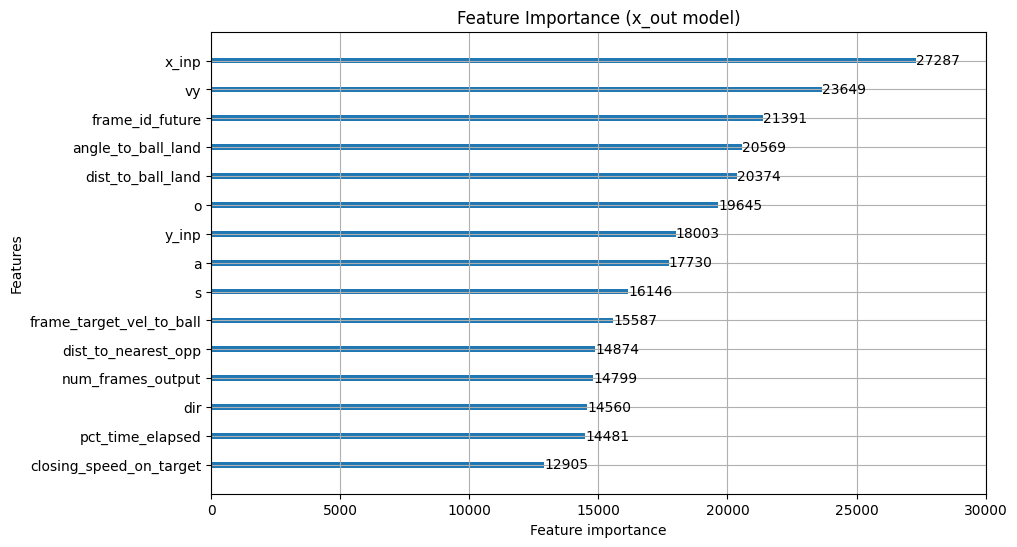

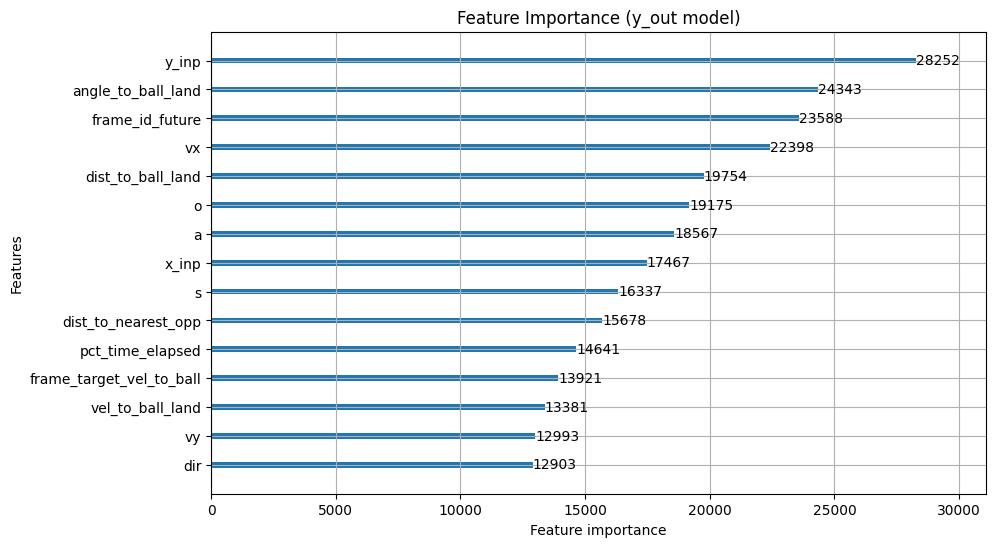

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance for the x_model
lgb.plot_importance(model_x, max_num_features=15, title="Feature Importance (x_out model)", figsize=(10, 6))
plt.show()

# Plot feature importance for the y_model
lgb.plot_importance(model_y, max_num_features=15, title="Feature Importance (y_out model)", figsize=(10, 6))
plt.show()

### Plot the Trajectory

Found existing plot on Google Drive: prediction_trajectory_comparison_LGBM_lr0_02_n8000_nl40.png. Loading...
Displaying existing plot. ✅


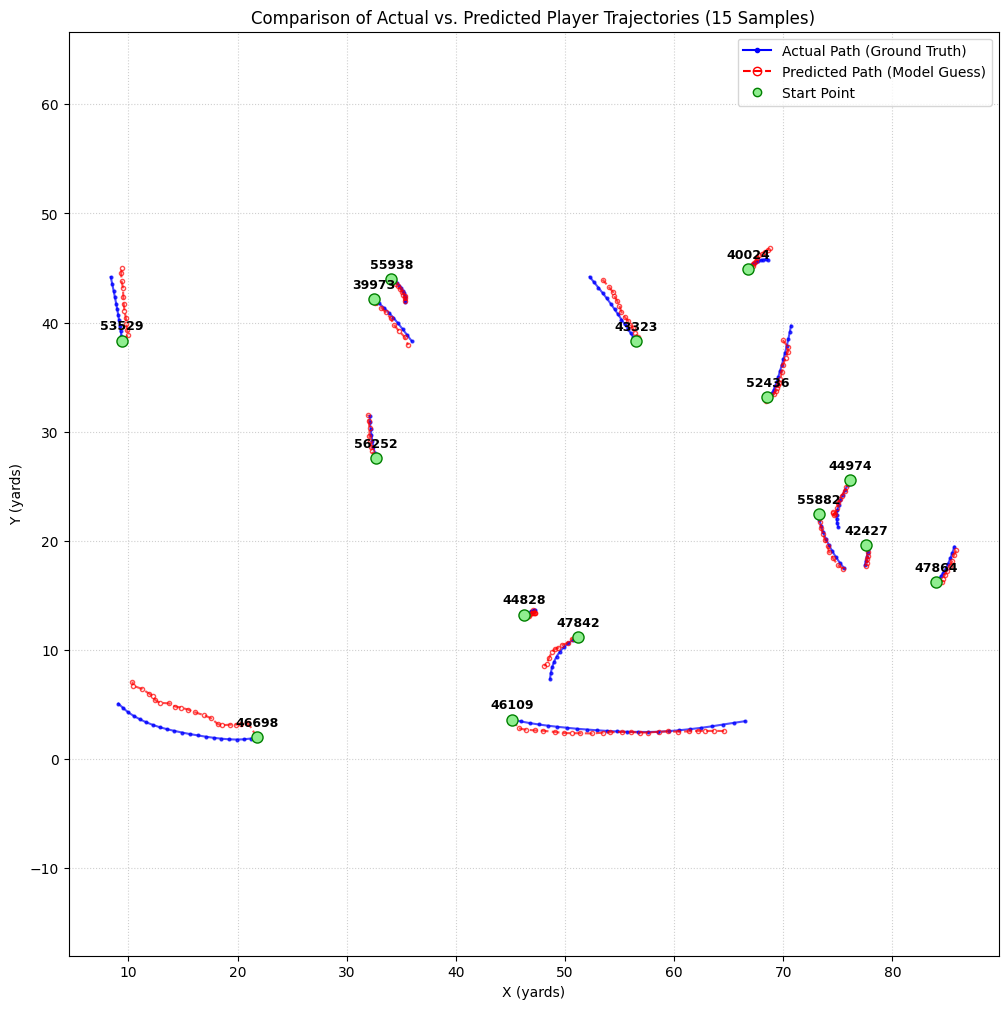

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib.lines import Line2D
from IPython.display import Image, display

# --- Define paths ---
if 'model_id_string' not in locals():
    print("Warning: 'model_id_string' not found. Using default filename.")
    model_id_string = "default_model"

plot_filename = f"prediction_trajectory_comparison_{model_id_string}.png"
local_plot_path = plot_filename
drive_plot_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/{plot_filename}"

# --- Check if plot exists ---

if os.path.exists(drive_plot_path):
    print(f"Found existing plot on Google Drive: {os.path.basename(drive_plot_path)}. Loading...")
    !cp "{drive_plot_path}" {local_plot_path}
    print("Displaying existing plot. ✅")
    display(Image(filename=local_plot_path))

else:
    # --- If file doesn't exist, create it ---
    print(f"Creating plot with NFL ID labels...")

    # --- Combine all the data into a single DataFrame ---
    plot_df = model_df[model_df['split'] == 'val'].copy()
    plot_df['x_pred'] = x_pred_lgbm
    plot_df['y_pred'] = y_pred_lgbm

    # --- Select a random sample of players to plot ---
    N_SAMPLES = 15

    unique_keys = plot_df[['game_id', 'play_id', 'nfl_id']].drop_duplicates()
    sample_keys = unique_keys.sample(N_SAMPLES, random_state=1337)
    sample_df = plot_df.merge(sample_keys, on=['game_id', 'play_id', 'nfl_id'])

    print(f"Plotting {N_SAMPLES} full trajectories...")

    # --- Create the plot ---
    plt.figure(figsize=(12, 12))

    # --- Draw the full trajectories for each player in the sample ---
    for (game, play, player), path_df in sample_df.groupby(['game_id', 'play_id', 'nfl_id']):

        path_df = path_df.sort_values('frame_id_future')

        # Get the start point
        start_x = path_df['x_inp'].iloc[0]
        start_y = path_df['y_inp'].iloc[0]

        # Construct the full paths (anchored to start)
        actual_path_x = np.concatenate([[start_x], path_df['x_out']])
        actual_path_y = np.concatenate([[start_y], path_df['y_out']])
        pred_path_x = np.concatenate([[start_x], path_df['x_pred']])
        pred_path_y = np.concatenate([[start_y], path_df['y_pred']])

        # 1. Plot "Actual Path"
        plt.plot(actual_path_x, actual_path_y,
                 color='blue', alpha=0.7, linestyle='-', marker='.', markersize=4, label='_nolegend_')

        # 2. Plot "Predicted Path"
        plt.plot(pred_path_x, pred_path_y,
                 color='red', alpha=0.7, linestyle='--', marker='o', markersize=3, mfc='none', label='_nolegend_')

        # 3. Plot "Start Point"
        plt.plot(start_x, start_y,
                 color='green', marker='o', markersize=8, mfc='lightgreen', label='_nolegend_')

        # --- Add the NFL ID Label ---
        # Offset the text slightly (y + 1) so it doesn't cover the green dot
        plt.text(start_x, start_y + 1, f"{int(player)}",
                 fontsize=9, color='black', fontweight='bold', ha='center')


    # --- Legend ---
    legend_elements = [
        Line2D([0], [0], color='blue', linestyle='-', marker='.', label='Actual Path (Ground Truth)'),
        Line2D([0], [0], color='red', linestyle='--', marker='o', mfc='none', label='Predicted Path (Model Guess)'),
        Line2D([0], [0], color='green', marker='o', mfc='lightgreen', linestyle='None', label='Start Point')
    ]

    # --- Plot and save the plot ---
    plt.title(f'Comparison of Actual vs. Predicted Player Trajectories ({N_SAMPLES} Samples)')
    plt.xlabel('X (yards)')
    plt.ylabel('Y (yards)')
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal')

    # Save the plot to the local path
    plt.savefig(local_plot_path, bbox_inches='tight')

    plt.close()
    print(f"Plot saved locally to: {local_plot_path}")

    # --- Copy to Google Drive ---
    drive_plot_dir = os.path.dirname(drive_plot_path)
    !mkdir -p "{drive_plot_dir}"

    print(f"Copying new plot to {drive_plot_path}...")
    !cp {local_plot_path} "{drive_plot_path}"
    print(f"New plot created, saved, and copied. ✅")

    # --- Display the newly created plot ---
    display(Image(filename=local_plot_path))

# Error Analysis

### Statistics and Worst Prediction Plot

In [ ]:
# Find the worst 100 predictions in validation set, see what they all have in common.

--- ERROR ANALYSIS ---

--- Top 15 Worst Predicted Frames (Raw Data) ---
           game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
476295  2023122404     1230   54502               True                    42   
476294  2023122404     1230   54502               True                    42   
476293  2023122404     1230   54502               True                    42   
476292  2023122404     1230   54502               True                    42   
241598  2023102909     3149   53463               True                    27   
476291  2023122404     1230   54502               True                    42   
476290  2023122404     1230   54502               True                    42   
241597  2023102909     3149   53463               True                    27   
241596  2023102909     3149   53463               True                    27   
337540  2023112300     2098   56097               True                    21   
476289  2023122404     1230   54502            

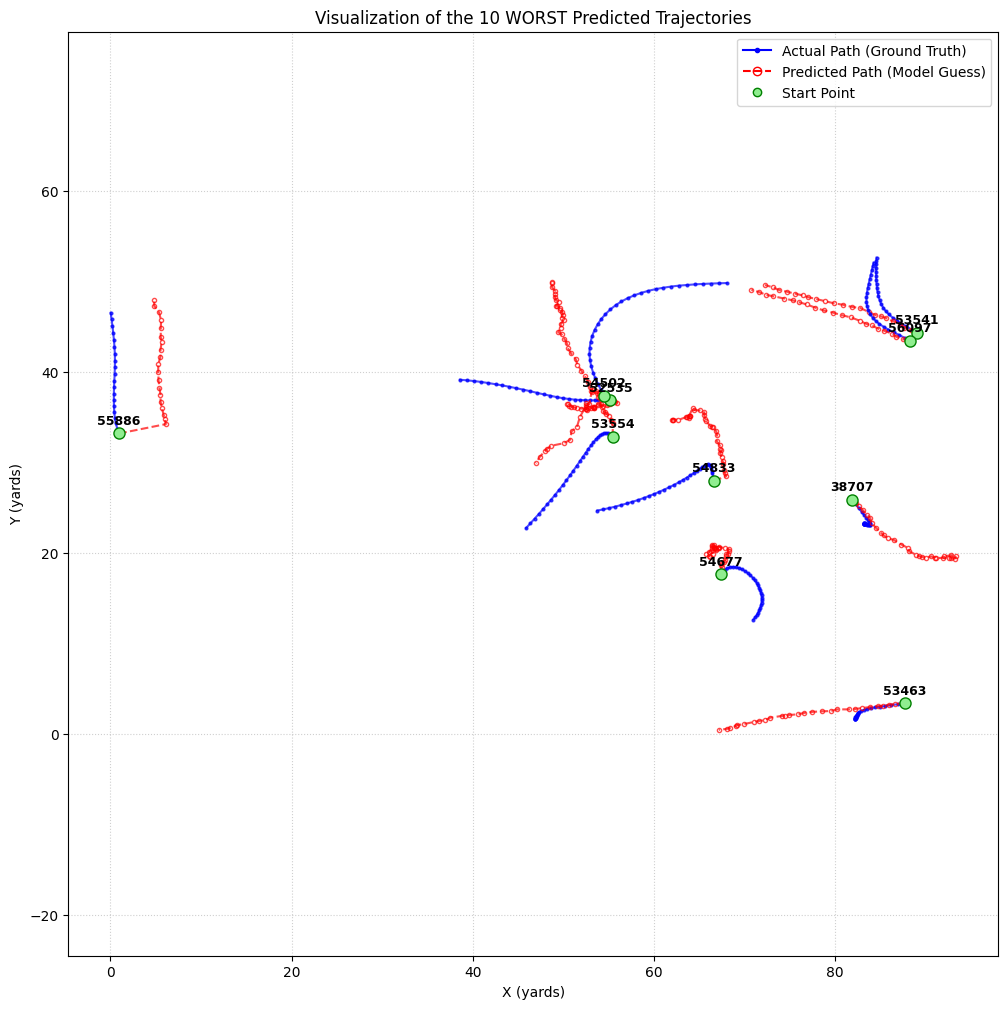

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib.lines import Line2D
from IPython.display import Image, display

# --- NUMERICAL ERROR ANALYSIS ---

print("--- ERROR ANALYSIS ---")

# Get the validation set's features and true values
analysis_df = model_df[model_df['split'] == 'val'].copy()
analysis_df['x_pred'] = x_pred_lgbm
analysis_df['y_pred'] = y_pred_lgbm

# Calculate the 'error_yards' (Euclidean distance) for each frame
analysis_df['error_yards'] = np.sqrt(
    (analysis_df['x_pred'] - analysis_df['x_out'])**2 +
    (analysis_df['y_pred'] - analysis_df['y_out'])**2
)

# Sort by the error to find the worst frames
worst_frames_df = analysis_df.sort_values('error_yards', ascending=False)

print("\n--- Top 15 Worst Predicted Frames (Raw Data) ---")
print(worst_frames_df.head(15))

print("\n--- Feature Averages (Worst 100 Frames vs. All) ---")
# Compare the worst 100 frames to the validation set's average
worst_100_stats = worst_frames_df.head(100)[feature_cols].mean()
all_val_stats = analysis_df[feature_cols].mean()

# Combine them for easy comparison
stats_comparison = pd.DataFrame({
    'Worst 100 Avg': worst_100_stats,
    'All Val Avg': all_val_stats,
})
stats_comparison['Difference (Percent)'] = 100 * (stats_comparison['Worst 100 Avg'] - stats_comparison['All Val Avg']) / stats_comparison['All Val Avg']

# Display features with the biggest difference
print(stats_comparison.sort_values('Difference (Percent)', ascending=False).head(10))
print("\n" + "="*50 + "\n")


# --- VISUAL ERROR ANALYSIS ---

# --- Define paths ---
if 'model_id_string' not in locals():
    print("Warning: 'model_id_string' not found. Using default filename.")
    model_id_string = "default_model"

plot_filename = f"worst_predictions_trajectory_{model_id_string}.png"
local_plot_path = plot_filename
drive_plot_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/{plot_filename}"

# --- Check if plot exists ---
if os.path.exists(drive_plot_path):
    print(f"Found existing plot on Google Drive: {os.path.basename(drive_plot_path)}. Loading...")
    !cp "{drive_plot_path}" {local_plot_path}
    print("Displaying existing plot. ✅")
    display(Image(filename=local_plot_path))

else:
    # --- If file doesn't exist, create it ---
    print(f"No plot found at {drive_plot_path}. Creating it now...")

    # Group by play and get the mean error for the whole trajectory
    worst_plays = analysis_df.groupby(
        ['game_id', 'play_id', 'nfl_id']
    )['error_yards'].mean().sort_values(ascending=False)

    # Get the keys for the N worst plays
    N_SAMPLES = 10
    sample_keys = worst_plays.head(N_SAMPLES).reset_index()[['game_id', 'play_id', 'nfl_id']]

    # Get all frames *only* for those N_SAMPLES worst player-plays
    sample_df = analysis_df.merge(sample_keys, on=['game_id', 'play_id', 'nfl_id'])

    print(f"Plotting the {N_SAMPLES} worst trajectories (by mean error)...")

    # --- Create the plot ---
    plt.figure(figsize=(12, 12))

    for (game, play, player), path_df in sample_df.groupby(['game_id', 'play_id', 'nfl_id']):

        path_df = path_df.sort_values('frame_id_future')

        # Get the single start point
        start_x = path_df['x_inp'].iloc[0]
        start_y = path_df['y_inp'].iloc[0]

        # Prepend the start point to the path arrays
        actual_path_x = np.concatenate([[start_x], path_df['x_out']])
        actual_path_y = np.concatenate([[start_y], path_df['y_out']])
        pred_path_x = np.concatenate([[start_x], path_df['x_pred']])
        pred_path_y = np.concatenate([[start_y], path_df['y_pred']])

        # 1. Plot Actual path
        plt.plot(actual_path_x, actual_path_y,
                 color='blue', alpha=0.7, linestyle='-', marker='.', markersize=4, label='_nolegend_')

        # 2. Plot Predicted path
        plt.plot(pred_path_x, pred_path_y,
                 color='red', alpha=0.7, linestyle='--', marker='o', markersize=3, mfc='none', label='_nolegend_')

        # 3. Plot Start point
        plt.plot(start_x, start_y,
                 color='green', marker='o', markersize=8, mfc='lightgreen', label='_nolegend_')

        # --- Add the NFL ID Label ---
        # Offset the text slightly (y + 1) so it doesn't cover the green dot
        plt.text(start_x, start_y + 1, f"{int(player)}",
                 fontsize=9, color='black', fontweight='bold', ha='center')

    # --- Legend ---
    legend_elements = [
        Line2D([0], [0], color='blue', linestyle='-', marker='.', label='Actual Path (Ground Truth)'),
        Line2D([0], [0], color='red', linestyle='--', marker='o', mfc='none', label='Predicted Path (Model Guess)'),
        Line2D([0], [0], color='green', marker='o', mfc='lightgreen', linestyle='None', label='Start Point')
    ]

    # --- Plot and save the plot ---
    plt.title(f'Visualization of the {N_SAMPLES} WORST Predicted Trajectories')
    plt.xlabel('X (yards)')
    plt.ylabel('Y (yards)')
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal')

    # Save the plot to the local path
    plt.savefig(local_plot_path, bbox_inches='tight')
    plt.close()
    print(f"Plot saved locally to: {local_plot_path}")

    # --- Copy to Google Drive ---
    drive_plot_dir = os.path.dirname(drive_plot_path)
    !mkdir -p "{drive_plot_dir}"

    print(f"Copying new plot to {drive_plot_path}...")
    !cp {local_plot_path} "{drive_plot_path}"
    print(f"New plot created, saved, and copied. ✅")

    # --- Display the newly created plot ---
    display(Image(filename=local_plot_path))

### Summary

Based on the feature averages (worst 100 vs. all), the failures are driven by specific, high-speed scenarios:

*   vy (Vertical Velocity): +1048%. This is the massive outlier. The model struggles to predict players running fast in the negative y direction (down the field). It has a severe directional bias.
*   time_to_predict: +207%. The model is accurate for the first second but falls apart when asked to predict 2.4 seconds ahead. The error compounds over time.
*   Distance from Action (+116% to ball, +94% to opponent). Counter-intuitively, the model fails when players are wide open in deep space. When a player is near an opponent, their path is constrained and predictable. When they are 25 yards away in open space, they have too much freedom, and the model guesses wrong.
*   pct_time_elapsed: +64%. Errors happen at the very end of plays (88% complete). The model understands structured routes (early play) but fails when players improvise late in the down.

Overall: The visual plots confirm that the model acts as a linear extrapolator. It assumes players will keep playing the game in a straight line based on their current speed. It completely fails to predict athletic inputs, such as sharp cuts, stops, or changes in direction, especially late in the play.



# More Feature Engineering


### Fix the Linear Extrapolation Problem

In [ ]:
def add_intent_features(df):
    print("Engineering Intent Features (Angle Diff, Braking, Sidelines)...")

    # --- Angle Difference ---
    # High diff implies a cut. Handles 360-degree wrap.
    diff = np.abs(df['o'] - df['dir'])
    df['angle_diff'] = np.where(diff > 180, 360 - diff, diff)

    # --- Sideline Proximity ---
    # Captures behavior near sidelines (53.3 yds wide).
    df['dist_to_sideline'] = np.minimum(df['y_inp'], 53.3 - df['y_inp'])

    # --- Out of Bounds Flag ---
    # Flags OOB players to teach model boundaries.
    df['is_oob'] = np.where((df['y_inp'] < 0) | (df['y_inp'] > 53.3), 1, 0)

    return df

# Apply to model_df
model_df = add_intent_features(model_df)

# Check the new features
print("\n--- New Physics Features ---")
print(model_df[['angle_diff', 'dist_to_sideline', 'is_oob']].describe())

Engineering Intent Features (Angle Diff, Braking, Sidelines)...

--- New Physics Features ---
          angle_diff  dist_to_sideline    is_oob
count  562936.000000     562936.000000  562936.0
mean       74.481041         16.409151       0.0
std        47.126934          5.838866       0.0
min         0.009979          0.680000       0.0
25%        36.080017         12.110001       0.0
50%        67.739990         16.379999       0.0
75%       107.889999         21.190001       0.0
max       180.000000         26.650000       0.0


In [ ]:
# --- Update Feature List ---
# Add the new features to the existing list
feature_cols_enhanced = feature_cols + ['angle_diff', 'dist_to_sideline', 'is_oob']

print(f"Training with {len(feature_cols_enhanced)} features...")

# --- Re-Split Data ---
X_train_enh = model_df[model_df['split'] == 'train'][feature_cols_enhanced]
y_train_enh = model_df[model_df['split'] == 'train'][target_cols]

X_val_enh = model_df[model_df['split'] == 'val'][feature_cols_enhanced]
y_val_enh = model_df[model_df['split'] == 'val'][target_cols]

import lightgbm as lgb
import os
from tqdm.auto import tqdm

# --- HELPER FUNCTION FOR TQDM PROGRESS BAR ---
def tqdm_callback(n_estimators):
    """A custom callback to display a tqdm progress bar."""
    pbar = tqdm(total=n_estimators, desc="Training Progress")

    def callback(env):
        pbar.update(1)

    return callback

# ---------------------------------------------

# --- Define hyperparameters ---
LEARNING_RATE = 0.02
N_ESTIMATORS_MAX = 8000
NUM_LEAVES = 40

# Added "_enhanced" tag to distinguish from the baseline model
model_id_string = f"LGBM_lr{str(LEARNING_RATE).replace('.', '_')}_n{N_ESTIMATORS_MAX}_nl{NUM_LEAVES}_enhanced"
print(f"Model ID: {model_id_string}")

# --- Define paths ---
drive_model_x_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_x.txt"
drive_model_y_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_y.txt"

# --- Check if models are already trained and saved ---
if os.path.exists(drive_model_x_path) and os.path.exists(drive_model_y_path):
    print(f"Found existing enhanced models on Google Drive. Loading...")

    # Load the models
    model_x_enhanced = lgb.Booster(model_file=drive_model_x_path)
    model_y_enhanced = lgb.Booster(model_file=drive_model_y_path)

    print("Models loaded successfully. ✅")

else:
    print("No trained enhanced models found. Starting training...")

    # --- Predict x_out ---
    print("\nTraining x_out model (Enhanced)...")
    model_x_enhanced = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE,
        num_leaves=NUM_LEAVES,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model_x_enhanced.fit(
        X_train_enh, y_train_enh['x_out'],
        eval_set=[(X_val_enh, y_val_enh['x_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=1000)
        ]
    )

    # --- Predict y_out ---
    print("\nTraining y_out model (Enhanced)...")
    model_y_enhanced = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE,
        num_leaves=NUM_LEAVES,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model_y_enhanced.fit(
        X_train_enh, y_train_enh['y_out'],
        eval_set=[(X_val_enh, y_val_enh['y_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=1000)
        ]
    )

    print("\nEnhanced model training complete.")

    print("Saving models to Google Drive...")

    model_dir = os.path.dirname(drive_model_x_path)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_x_enhanced.booster_.save_model(drive_model_x_path)
    model_y_enhanced.booster_.save_model(drive_model_y_path)
    print("Models saved. ✅")

Training with 25 features...
Model ID: LGBM_lr0_02_n8000_nl40_enhanced
No trained enhanced models found. Starting training...

Training x_out model (Enhanced)...


Training Progress:   0%|          | 0/8000 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4794
[LightGBM] [Info] Number of data points in the train set: 388089, number of used features: 24
[LightGBM] [Info] Start training from score 60.249880
[1000]	valid_0's rmse: 1.10216	valid_0's l2: 1.21476
[2000]	valid_0's rmse: 1.05288	valid_0's l2: 1.10857
[3000]	valid_0's rmse: 1.0315	valid_0's l2: 1.064
[4000]	valid_0's rmse: 1.02245	valid_0's l2: 1.04541
[5000]	valid_0's rmse: 1.01677	valid_0's l2: 1.03381
[6000]	valid_0's rmse: 1.01224	valid_0's l2: 1.02464
[7000]	valid_0's rmse: 1.00851	valid_0's l2: 1.0171
[8000]	valid_0's rmse: 1.00645	valid_0's l2: 1.01295

Training y_out model (Enhanced)...


Training Progress:   0%|          | 0/8000 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4794
[LightGBM] [Info] Number of data points in the train set: 388089, number of used features: 24
[LightGBM] [Info] Start training from score 26.708749
[1000]	valid_0's rmse: 0.95835	valid_0's l2: 0.918434
[2000]	valid_0's rmse: 0.926889	valid_0's l2: 0.859123
[3000]	valid_0's rmse: 0.915806	valid_0's l2: 0.8387
[4000]	valid_0's rmse: 0.910398	valid_0's l2: 0.828825
[5000]	valid_0's rmse: 0.906389	valid_0's l2: 0.821541
[6000]	valid_0's rmse: 0.903153	valid_0's l2: 0.815686
[7000]	valid_0's rmse: 0.900399	valid_0's l2: 0.810718
[8000]	valid_0's rmse: 0.898379	valid_0's l2: 0.807084

Enhanced model training complete.
Saving models to Google Drive...
Models saved. ✅


In [ ]:
# --- Evaluate improvement ---
x_pred_enh = model_x_enhanced.predict(X_val_enh)
y_pred_enh = model_y_enhanced.predict(X_val_enh)

# Calculate RMSE
enh_errors = np.sqrt((x_pred_enh - y_val_enh['x_out'])**2 + (y_pred_enh - y_val_enh['y_out'])**2)
enh_rmse = enh_errors.mean()

print(f"\n--- Results Summary ---")
print(f"Baseline (Physics) RMSE:   {baseline_rmse:.4f}")
print(f"Previous LightGBM RMSE:    {lgbm_rmse:.4f}")
print(f"Enhanced LightGBM RMSE:    {enh_rmse:.4f}")

# Calculate gain
gain = lgbm_rmse - enh_rmse
print(f"Improvement from Feature Eng: {gain:.4f} yards per frame")


--- Results Summary ---
Baseline (Physics) RMSE:   6.0026
Previous LightGBM RMSE:    0.8828
Enhanced LightGBM RMSE:    0.8768
Improvement from Feature Eng: 0.0060 yards per frame


LighGBM is a snapshot model. It looks at one frame and guesses. It doesn't have memory of the past 10 frames to know a route trajectory. To fix trajectory prediction, we need to switch to an LSTM or Transformer.

# LSTM

# Push Codes to GitHUb

### Set Up Git and Clone Repo

In [ ]:
import os
import shutil
from google.colab import userdata

# --- Configuration ---
USERNAME = "ellydo17"
REPO_NAME = "nfl-big-data-bowl-2026-ma-797"

# --- Authentication ---
try:
    GH_TOKEN = userdata.get('GH_TOKEN')
except KeyError:
    print("Error: 'GH_TOKEN' not found in userdata.")
    raise

# Configure Git
!git config --global user.name "{USERNAME}"
!git config --global user.email "{USERNAME}@users.noreply.github.com"

# --- Safe Clone Logic ---
repo_url = f"https://{GH_TOKEN}@github.com/{USERNAME}/{REPO_NAME}.git"

# 1. Check if the folder already exists and delete it to avoid conflicts
if os.path.exists(REPO_NAME):
    print(f"Removing existing '{REPO_NAME}' folder to ensure a clean clone...")
    shutil.rmtree(REPO_NAME)

# 2. Clone the existing repository
print(f"Cloning {REPO_NAME} from GitHub...")
!git clone {repo_url}

print("✅ Repository cloned successfully!")

In [ ]:
# %%writefile /content/{REPO_NAME}/.gitignore
# *.parquet
# *.csv
# Models/
# *.txt
# .ipynb_checkpoints/
# __pycache__/

### Remove 'Widgets' Metadata

In [2]:
import json

notebook_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl_big_data_bowl_2026_stronger_model.ipynb"

print(f"Scanning {notebook_path} for errors...")

# --- LOAD THE NOTEBOOK DATA ---
with open(notebook_path, 'r', encoding='utf-8') as f:
    nb_data = json.load(f)

# --- REMOVE THE OFFENDING METADATA ---
if 'widgets' in nb_data['metadata']:
    print("Found incompatible 'widgets' metadata. Removing it...")
    del nb_data['metadata']['widgets']

    # --- OVERWRITE THE FILE WITH THE FIXED VERSION ---
    with open(notebook_path, 'w', encoding='utf-8') as f:
        json.dump(nb_data, f, indent=1)

    print("✅ Notebook repaired! It is now safe to push to GitHub.")

else:
    print("No 'widgets' metadata found. The notebook is already clean.")

Scanning /content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl_big_data_bowl_2026_stronger_model.ipynb for errors...
Found incompatible 'widgets' metadata. Removing it...
✅ Notebook repaired! It is now safe to push to GitHub.


### Push Codes

In [3]:
import os

source_notebook = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl_big_data_bowl_2026_stronger_model.ipynb"
source_figures = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures"

print("Copying files from Drive to Git folder...")

!cp "{source_notebook}" /content/{REPO_NAME}/

if os.path.exists(source_figures):
    !cp -r "{source_figures}" /content/{REPO_NAME}/
else:
    print("Warning: Figures folder not found in Drive path.")

%cd /content/{REPO_NAME}
!git add .
!git commit -m "Wrap up LightGBM model"
!git push origin main
print("\n✅ Success! Files pushed to GitHub.")

Copying files from Drive to Git folder...
cp: cannot stat '{source_notebook}': No such file or directory
cp: cannot stat '{source_figures}': No such file or directory
[Errno 2] No such file or directory: '/content/{REPO_NAME}'
/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git

✅ Success! Files pushed to GitHub.
